# Model for audio data

In [34]:
import os

MODEL_METADATA = "RF"
model_name = "efficientnet_v2_m"#"efficientnet_b7"## "mobilenet_v3_large"#"convnext_base"
EXPERIMENT_NAME = f"{model_name}_embeddings"
results_path = f"{EXPERIMENT_NAME}/{MODEL_METADATA}"
os.makedirs(results_path, exist_ok = True)
os.makedirs(EXPERIMENT_NAME, exist_ok = True)
train_path = f"{EXPERIMENT_NAME}/train"
val_path = f"{EXPERIMENT_NAME}/val"
os.makedirs(train_path, exist_ok = True)
os.makedirs(val_path, exist_ok=True)

# Utility functions

In [35]:
import sys
sys.path.insert(0,'../') 
# from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split
from torch.utils.data import Subset, DataLoader, random_split

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd 

import argparse

import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter


# import models_vit
import sys
import os
import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
# import models_mae
import torch; print(f'numpy version: {np.__version__}\nCUDA version: {torch.version.cuda} - Torch versteion: {torch.__version__} - device count: {torch.cuda.device_count()}')

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.optim as optim
import torch.nn as nn
import torch

import PIL
import pandas as pd
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score
import numpy as np
from torchvision import datasets, transforms
from timm.data import create_transform
# from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

IMAGENET_DEFAULT_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_DEFAULT_STD = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * IMAGENET_DEFAULT_STD + IMAGENET_DEFAULT_MEAN) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def plot_multiclass_roc_curve(all_labels, all_predictions, results_path="."):
    # Step 1: Label Binarization
    label_binarizer = LabelBinarizer()
    y_onehot = label_binarizer.fit_transform(all_labels)
    all_predictions_hot = label_binarizer.transform(all_predictions)

    # Step 2: Calculate ROC curves
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    unique_classes = range(y_onehot.shape[1])
    for i in unique_classes:
        fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], all_predictions_hot[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Step 3: Plot ROC curves
    fig, ax = plt.subplots(figsize=(8, 8))

    # Micro-average ROC curve
    fpr_micro, tpr_micro, _ = roc_curve(y_onehot.ravel(), all_predictions_hot.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(
        fpr_micro,
        tpr_micro,
        label=f"micro-average ROC curve (AUC = {roc_auc_micro:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    # Macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in unique_classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in unique_classes:
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(unique_classes)
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    plt.plot(
        fpr_macro,
        tpr_macro,
        label=f"macro-average ROC curve (AUC = {roc_auc_macro:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    # Individual class ROC curves with unique colors
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_classes)))
    for class_id, color in zip(unique_classes, colors):
        plt.plot(
            fpr[class_id],
            tpr[class_id],
            color=color,
            label=f"ROC curve for Class {class_id} (AUC = {roc_auc[class_id]:.2f})",
            linewidth=2,
        )

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2)  # Add diagonal line for reference
    plt.axis("equal")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\n to One-vs-Rest multiclass")
    plt.legend()
    plt.savefig(f'{results_path}/roc_curve.png')
    plt.show()


def build_dataset(is_train, args):
    transform = build_transform(is_train, args)

    root = os.path.join(args.data_path, 'train' if is_train else 'val')
    dataset = datasets.ImageFolder(root, transform=transform)

    print(dataset)

    return dataset


def build_transform(is_train, args):
    mean = IMAGENET_DEFAULT_MEAN
    std = IMAGENET_DEFAULT_STD
    # train transform
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=args.input_size,
            is_training=True,
            color_jitter=args.color_jitter,
            auto_augment=args.aa,
            interpolation='bicubic',
            re_prob=args.reprob,
            re_mode=args.remode,
            re_count=args.recount,
            mean=mean,
            std=std,
        )
        return transform

    # eval transform
    t = []
    if args.input_size <= 224:
        crop_pct = 224 / 256
    else:
        crop_pct = 1.0
    size = int(args.input_size / crop_pct)
    t.append(
        transforms.Resize(size, interpolation=PIL.Image.BICUBIC),  # to maintain same ratio w.r.t. 224 images
    )
    t.append(transforms.CenterCrop(args.input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(mean, std))
    return transforms.Compose(t)

# Set the seed for PyTorch
torch.manual_seed(42)

numpy version: 1.26.4
CUDA version: 11.8 - Torch versteion: 2.0.0+cu118 - device count: 2


# Random Forest (RF)

In [36]:
# Read embeddings CSV files
train_embeddings = pd.read_csv(f'{train_path}/train_embeddings.csv')
val_embeddings = pd.read_csv(f'{val_path}/val_embeddings.csv')
print(f"Reading embeddings from: ", train_path)

# Prepare data for training
X_train = train_embeddings.iloc[:, :-1].values  # Features
y_train = train_embeddings.iloc[:, -1].values   # Labels

X_val = val_embeddings.iloc[:, :-1].values      # Features
y_val = val_embeddings.iloc[:, -1].values       # Labels

# Train a Random Forest Classifier

# Use los mejores parámetros encontrados
# best_params = {'max_depth': 80, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}

# Inicializa el clasificador SVM con los mejores parámetros
rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)

# Predict on validation data
y_pred = rf_classifier.predict(X_val)
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)

# Calculate precision
precision = precision_score(y_val, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_val, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_val, y_pred, average='weighted')

# Calculate F0.75 score
fbeta_75 = fbeta_score(y_val, y_pred, beta=0.75, average='weighted')

print("Validation Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("F0.75 Score:", fbeta_75)

Reading embeddings from:  efficientnet_v2_m_embeddings/train
Validation Accuracy: 0.6082352941176471
Precision: 0.6723499383714112
Recall: 0.6082352941176471
F1 Score: 0.6048122755837748
F0.75 Score: 0.6165394814006099


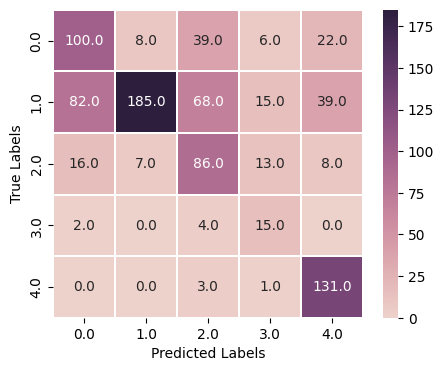

In [37]:
unique_classes = np.unique(np.concatenate(((y_pred, y_val))))
confusion_mat = confusion_matrix(y_pred, y_val, labels=unique_classes)
conf_matrix = pd.DataFrame(confusion_mat, index=unique_classes, columns=unique_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
ax = sns.heatmap(conf_matrix, annot=True,  fmt='.1f', cmap=sns.cubehelix_palette(as_cmap=True), linewidths=0.1, cbar=True)

# Set labels and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Set x and y ticks using the unique classes
ax.set_xticks(range(len(unique_classes)))
ax.set_yticks(range(len(unique_classes)))

# Set x and y ticks at the center of the cells
ax.set_xticks([i + 0.5 for i in range(len(unique_classes))])
ax.set_yticks([i + 0.5 for i in range(len(unique_classes))])

plt.show()

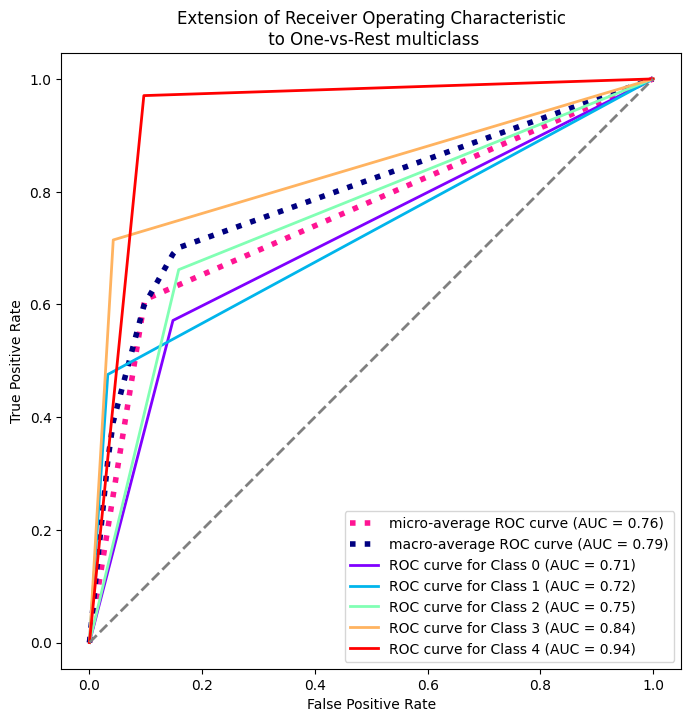

In [38]:
plot_multiclass_roc_curve(y_pred, y_val, results_path)

In [39]:
report = classification_report(y_val,y_pred, target_names=unique_classes,output_dict=True)# Mostrar el informe de 

df = pd.DataFrame(report).transpose()
df.to_csv(os.path.join(results_path, f"confusion_matrix_{MODEL_METADATA}.csv"))
print(df)

              precision    recall  f1-score     support
0.0            0.571429  0.500000  0.533333  200.000000
1.0            0.475578  0.925000  0.628183  200.000000
2.0            0.661538  0.430000  0.521212  200.000000
3.0            0.714286  0.300000  0.422535   50.000000
4.0            0.970370  0.655000  0.782090  200.000000
accuracy       0.608235  0.608235  0.608235    0.608235
macro avg      0.678640  0.562000  0.577471  850.000000
weighted avg   0.672350  0.608235  0.604812  850.000000


In [40]:
# Calculate precision, recall, and specificity (micro-averaged)
precision = precision_score(y_val, y_pred, average='micro')
recall = recall_score(y_val, y_pred, average='micro')

# Calculate true negatives, false positives, and specificity (micro-averaged)
tn = np.sum((y_val != 1) & (y_pred != 1))
fp = np.sum((y_val != 1) & (y_pred == 1))
specificity = tn / (tn + fp)

# Calculate F1 score (weighted average)
f1 = f1_score(y_val, y_pred, average='weighted')
fbeta_75 = fbeta_score(y_val, y_pred, beta=0.75, average='weighted')

evaluation_metrics = {
    "Accuracy": accuracy,
    "F1 Score": f1,
    "F0.75 Score": fbeta_75,
    "Precision": precision,
    "Recall": recall,
    "Specificity": specificity
}

print("Evaluation Metrics:")
# for metric, value in evaluation_metrics.items():
#     print(f"{metric}: {value}")
# Create a DataFrame from the dictionary
df = pd.DataFrame(evaluation_metrics, index=[0]) 

# # Save the DataFrame to a CSV file
df.to_csv(f'{results_path}/evaluation_metrics_for_table_{MODEL_METADATA}.csv', index=False)
df

Evaluation Metrics:


,Accuracy,F1 Score,F0.75 Score,Precision,Recall,Specificity
0,0.608235,0.604812,0.616539,0.608235,0.608235,0.686154


In [41]:
results_path

'efficientnet_v2_m_embeddings/RF'

# Grid search

In [17]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

# # Define the parameter grid to search
# param_grid = {
#     'classifier__n_estimators': [50, 100, 150],
#     'classifier__max_depth': [None, 10, 20],
#     'classifier__min_samples_split': [2, 5, 10],
#     'classifier__min_samples_leaf': [1, 2, 4]
# }

# # Create a pipeline with normalization and RandomForestClassifier
# rf_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])

# # Create GridSearchCV
# grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=3, scoring='accuracy')

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

# # Use the best estimator found by GridSearchCV
# best_rf_classifier = grid_search.best_estimator_

# # Predict on validation data using the best model
# y_pred = best_rf_classifier.predict(X_val)

# # Calculate metrics
# accuracy = accuracy_score(y_val, y_pred)
# precision = precision_score(y_val, y_pred, average='weighted')
# recall = recall_score(y_val, y_pred, average='weighted')
# f1 = f1_score(y_val, y_pred, average='weighted')
# fbeta_75 = fbeta_score(y_val, y_pred, beta=0.75, average='weighted')

# print("Validation Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)
# print("F0.75 Score:", fbeta_75)

